In [ ]:
#default_exp augmentations

# Augmentations

> Utilities for creating augmentation pipelines mentioned in popular self supervised learning papers.

In [ ]:
#export
from fastai.vision.all import *
import kornia
import torchvision.transforms as tvtfm

In [ ]:
#hide
# kornia.__version__ 0.4.1
# torchvision.__version__ 0.8.2

In [ ]:
#export
def _gauss_blur2d(x,s):
    "Apply gaussian_blur2d kornia filter"
    s2 = int(s/4)*2+1
    x2 = unsqueeze(x, dim=0, n=4-x.dim())
    res = kornia.filters.gaussian_blur2d(x2, (s2,s2), (s,s), 'replicate')
    return res.squeeze()

class GaussBlur2D(RandTransform):
    "Randomly apply gaussian blur with probability `p` with a value of s"
    order = 11
    def __init__(self, p=0.5, s=(8,32), batch=False, **kwargs): 
        store_attr()
        super().__init__(p=p)
    def encodes(self, x:TensorImage):
        if isinstance(self.s, tuple): s = np.random.randint(*self.s)
        if isinstance(self.s, list):  s = np.random.randint(*self.s)
        if isinstance(self.s, int):   s = self.s
        return _gauss_blur2d(x,s)

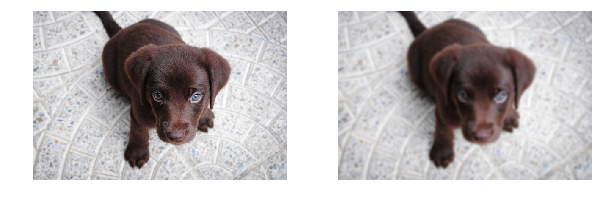

In [ ]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
pipe = Pipeline([ToTensor(), IntToFloatTensor(), GaussBlur2D(1.,(8,32))])
pipe.split_idx = 0
t1,t2 = Pipeline([ToTensor(), IntToFloatTensor()])(img), pipe(img)
show_images([t1, t2], figsize=(10,20))

## Kornia

Kornia has ability to pass `same_on_batch` argument. If it's set to False, then augmentation will be randomly applied to elements of a batch.

In [ ]:
#export
def get_kornia_batch_augs(size,
                        jitter=True,
                        bw=True,
                        blur=True,
                        resize_scale=(0.2, 1.0),
                        resize_ratio=(3/4, 4/3),
                        s=.6,  
                        blur_s=(8,32),
                        same_on_batch=False,
                        stats_args=imagenet_stats,
                        xtra_tfms=[]):
    "Input batch augmentations implemented in kornia"
    tfms = []
    tfms += [kornia.augmentation.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio, interpolation=2, same_on_batch=same_on_batch)]
    tfms += [kornia.augmentation.RandomHorizontalFlip(p=0.5)]
    
    if jitter: tfms += [kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s, p=0.3, same_on_batch=same_on_batch)]
    if bw:     tfms += [kornia.augmentation.RandomGrayscale(p=0.3, same_on_batch=same_on_batch)]   
    if blur:   tfms += [GaussBlur2D(p=0.3, s=blur_s)]
        
    if stats_args is not None: tfms += [Normalize.from_stats(*stats_args)]

    tfms += xtra_tfms
    pipe = Pipeline(tfms); pipe.split_idx = 0
    return pipe

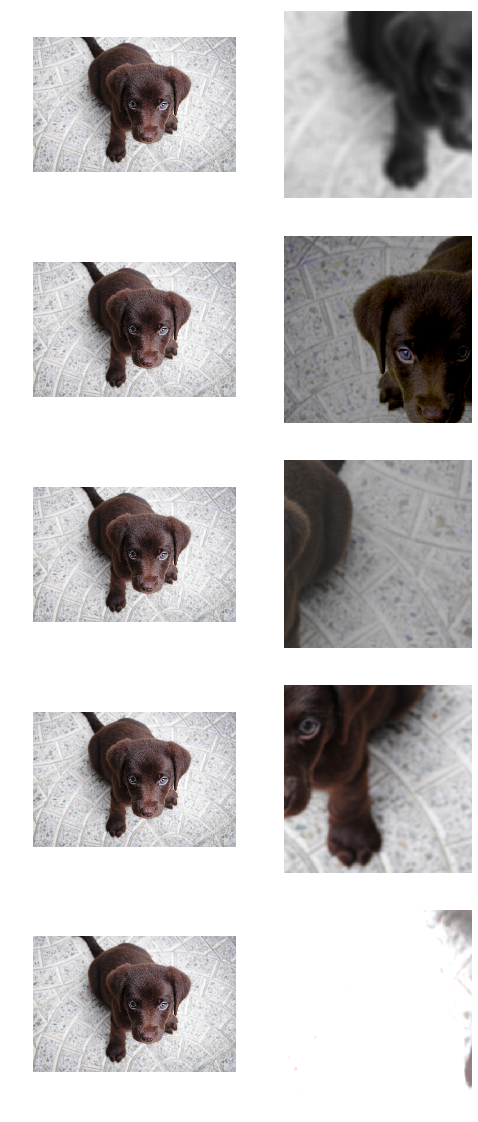

In [ ]:
aug, n = get_kornia_batch_augs(336, resize_scale=(0.2,1), stats_args=(*imagenet_stats,1,4,False), same_on_batch=False), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

GPU batch transforms are ~10x - ~20x faster than CPU depending on image size. Larger image sizes benefit from the GPU more.

In [ ]:
xb = (torch.stack([t1]*32))
aug= get_kornia_batch_augs(336, resize_scale=(0.75,1), stats_args=(*imagenet_stats,1,4,False))

In [ ]:
%%timeit
out = aug(xb)

275 ms ± 34.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
xb = xb.to(default_device())
aug = get_kornia_batch_augs(336, resize_scale=(0.75,1), stats_args=imagenet_stats)

In [ ]:
%%timeit
out = aug(xb)

27.7 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
xb = xb.to(default_device())
aug = get_kornia_batch_augs(336, resize_scale=(0.75,1), same_on_batch=True, stats_args=imagenet_stats)

In [ ]:
%%timeit
out = aug(xb)

15.3 ms ± 592 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Torchvision

In [ ]:
#export
def get_torchvision_batch_augs(size,
                            jitter=True,
                            bw=True,
                            blur=True,
                            resize_scale=(0.2, 1.0),
                            resize_ratio=(3/4, 4/3),
                            s=.6,  
                            blur_s=(8,32),
                            stats_args=imagenet_stats,
                            xtra_tfms=[]):
    "Input batch augmentations implemented in torchvision"
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    tfms += [tvtfm.RandomHorizontalFlip(p=0.5)]
    
    if jitter: tfms += [tvtfm.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)]
    if bw:     tfms += [tvtfm.RandomGrayscale(p=0.3)]   
    if blur:   tfms += [GaussBlur2D(p=0.3, s=blur_s)]
        
    tfms += xtra_tfms
    if stats_args is not None: tfms += [Normalize.from_stats(*stats_args)]

    pipe = Pipeline(tfms); pipe.split_idx = 0
    return pipe

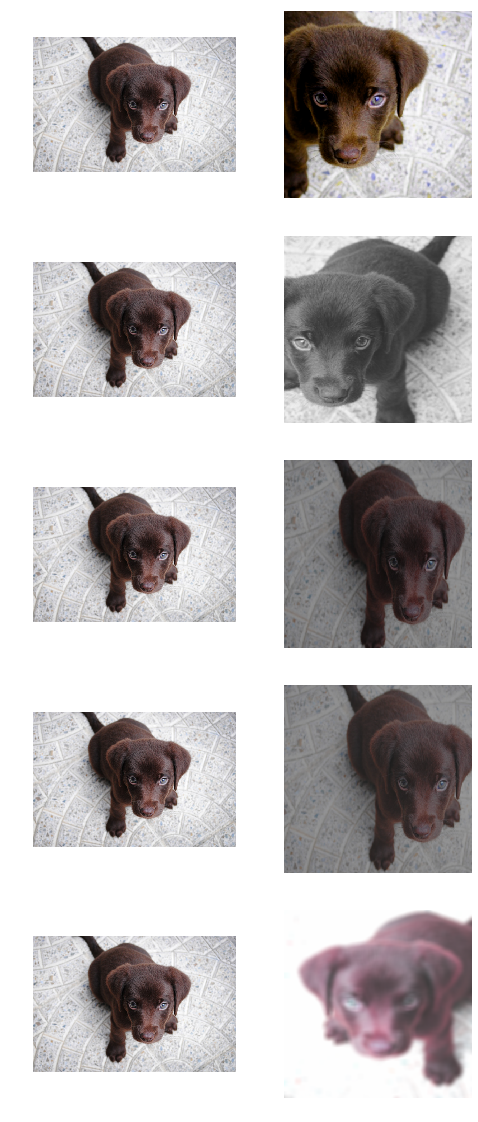

In [ ]:
aug, n = get_torchvision_batch_augs(336, resize_scale=(0.2, 1), stats_args=(*imagenet_stats,1,4,False)), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

Torchvision is slightly faster than kornia `same_on_batch=True`.

In [ ]:
xb = (torch.stack([t1]*32))
aug= get_torchvision_batch_augs(336, resize_scale=(0.75,1), stats_args=(*imagenet_stats,1,4,False))

In [ ]:
%%timeit
out = aug(xb)

628 ms ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
xb = xb.to(default_device())
aug = get_torchvision_batch_augs(336, resize_scale=(0.75,1), stats_args=imagenet_stats)

In [ ]:
%%timeit
out = aug(xb)

18.3 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Kornia + Torchvision

In [ ]:
#export
def get_batch_augs(size,
                    jitter=True,
                    bw=True,
                    blur=True,
                    resize_scale=(0.2, 1.0),
                    resize_ratio=(3/4, 4/3),
                    s=.6,  
                    blur_s=(8,32),
                    same_on_batch=False,
                    stats_args=imagenet_stats,
                    xtra_tfms=[]):
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    tfms += [kornia.augmentation.RandomHorizontalFlip(p=0.5)]
    
    if jitter: tfms += [kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s, p=0.3, same_on_batch=same_on_batch)]
    if bw:     tfms += [kornia.augmentation.RandomGrayscale(p=0.3, same_on_batch=same_on_batch)]   
    if blur:   tfms += [GaussBlur2D(p=0.3, s=blur_s)]
        
    if stats_args is not None: tfms += [Normalize.from_stats(*stats_args)]

    tfms += xtra_tfms
    pipe = Pipeline(tfms); pipe.split_idx = 0
    return pipe

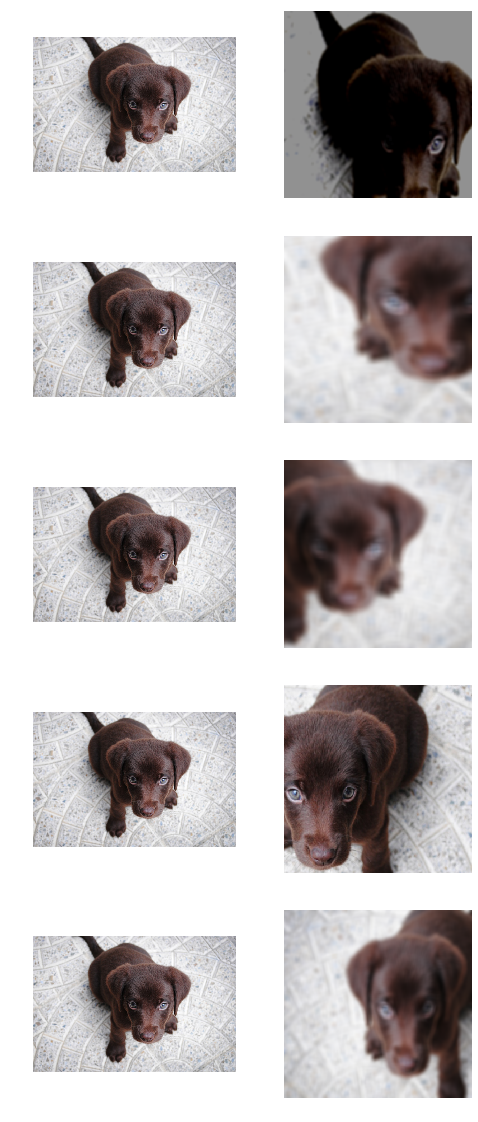

In [ ]:
aug, n = get_batch_augs(336, resize_scale=(0.2, 1), stats_args=(*imagenet_stats,1,4,False)), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

Torchvision is slightly faster than kornia `same_on_batch=True`.

In [ ]:
xb = (torch.stack([t1]*32))
aug= get_batch_augs(336, resize_scale=(0.75,1), stats_args=(*imagenet_stats,1,4,False))

In [ ]:
%%timeit
out = aug(xb)

159 ms ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
xb = xb.to(default_device())
aug = get_batch_augs(336, resize_scale=(0.75,1), stats_args=imagenet_stats)

In [ ]:
%%timeit
out = aug(xb)

17.5 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Adding extra tfms

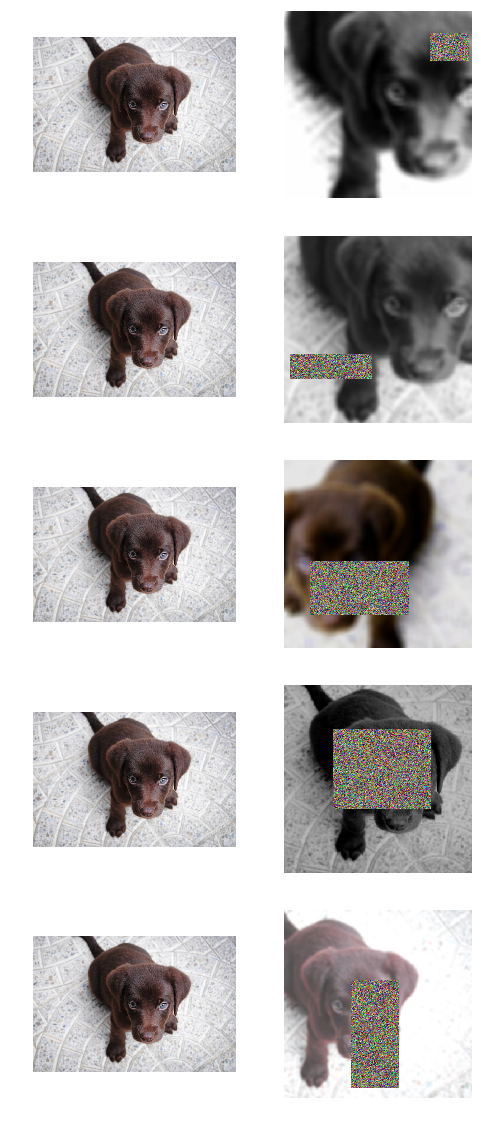

In [ ]:
aug, n = get_torchvision_batch_augs(336, resize_scale=(0.2, 1), stats_args=(*imagenet_stats,1,4,False),xtra_tfms=[RandomErasing(p=1.)]), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00-utils.ipynb.
Converted 01-augmentations.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
